# The Analysis of the Relationship Between MLB Umpires and the Game Result

The dataset used here 'mlb-umpire-scorecard.csv' is from the following link.  
https://www.kaggle.com/datasets/mattop/mlb-baseball-umpire-scorecards-2015-2022

In [125]:
import psycopg2
from psycopg2 import sql
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Common function to get connection to DB
def get_connection():
    db_config = {
    "dbname": "baseball",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": "5432",
    }

    try:
        # Connect to DB
        conn = psycopg2.connect(**db_config)
        return conn
    except psycopg2.Error as e:
        print("Error: ", e)
        return None

Data setup

In [126]:
table_name = "umpire_scorecard"

try:
    conn = get_connection()
    cur = conn.cursor()

    # Drop umpire_scorecard table
    cur.execute(
        sql.SQL(
            """
            DROP TABLE IF EXISTS {}
            """
        ).format(sql.Identifier(table_name))
    )

    # Create umpire_scorecard table
    cur.execute(
        sql.SQL(
            """
        CREATE TABLE {} (
            id INTEGER PRIMARY KEY,
            date DATE,
            umpire VARCHAR(255),
            home VARCHAR(50),
            away VARCHAR(50),
            home_team_runs INTEGER,
            away_team_runs INTEGER,
            pitches_called INTEGER,
            incorrect_calls INTEGER,
            expected_incorrect_calls FLOAT,
            correct_calls INTEGER,
            expected_correct_calls FLOAT,
            correct_calls_above_expected FLOAT,
            accuracy FLOAT,
            expected_accuracy FLOAT,
            accuracy_above_expected FLOAT,
            consistency FLOAT,
            favor_home FLOAT,
            total_run_impact FLOAT
        );
        """
        ).format(sql.Identifier(table_name))
    )

    # Insert data
    file = open("mlb-umpire-scorecard.csv", mode="r", encoding="utf-8")

    cur.copy_expert(
        sql.SQL(
            """
            COPY {}
            FROM STDIN
            WITH CSV HEADER
            NULL AS 'ND'
            """
        ).format(sql.Identifier(table_name)),
        file,
    )

    # Commit the changes
    conn.commit()

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

Display the head of the data

In [127]:
try:
    conn = get_connection()    
    query = sql.SQL("SELECT * FROM {};").format(sql.Identifier(table_name)).as_string(conn)
    data = pd.read_sql_query(query, conn)
    print(data.head())

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

   id        date           umpire home away  home_team_runs  away_team_runs  \
0   1  2022-11-05  Lance Barksdale  HOU  PHI               4               1   
1   2  2022-11-03     Jordan Baker  PHI  HOU               2               3   
2   3  2022-11-02     Tripp Gibson  PHI  HOU               0               5   
3   4  2022-11-01     Dan Iassogna  PHI  HOU               7               0   
4   5  2022-10-29       Pat Hoberg  HOU  PHI               5               2   

   pitches_called  incorrect_calls  expected_incorrect_calls  correct_calls  \
0           124.0              4.0                      10.0          120.0   
1           149.0              6.0                       7.4          143.0   
2           124.0              7.0                       7.1          117.0   
3           140.0              5.0                       6.0          135.0   
4           129.0              0.0                       8.7          129.0   

   expected_correct_calls  correct_calls_abo

/var/folders/m7/2d5d832j3j300wwm7q5ptzdh0000gn/T/ipykernel_30644/3461262175.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)


## Who's the best umpire?

### 1. Average Accuracy and Consistency by Umpires

Is there a relationship between accuracy and consistency?

/var/folders/m7/2d5d832j3j300wwm7q5ptzdh0000gn/T/ipykernel_30644/824757591.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)


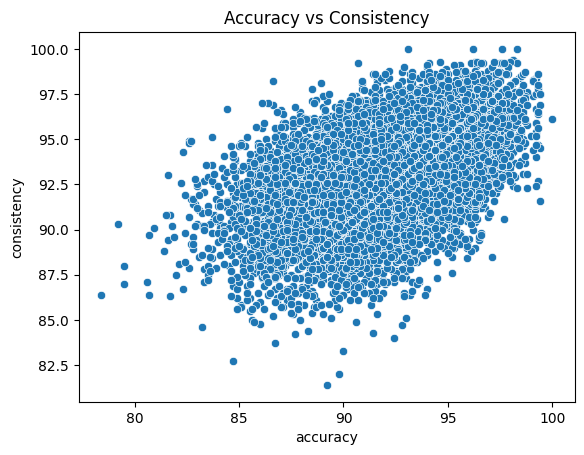

In [128]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT accuracy, consistency
            FROM {};
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)
    sns.scatterplot(data=data, x='accuracy', y='consistency')
    plt.title('Accuracy vs Consistency')
    plt.show()

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

According to the chart, it seems that they are proportionally related.

In [129]:
try:
    conn = get_connection()
    query = (
        sql.SQL(
            """
            SELECT umpire, 
                AVG(accuracy) as avg_accu, 
                AVG(consistency) as avg_cons,
                AVG(accuracy_above_expected) as avg_accu_abv_exp,
                AVG(favor_home) as avg_fav_home
            FROM {}
            GROUP BY umpire;
            """
        )
        .format(sql.Identifier(table_name))
        .as_string(conn)
    )
    data = pd.read_sql_query(query, conn)
    print(data.head())

except psycopg2.Error as e:
    print("Error: ", e)

finally:
    cur.close()
    conn.close()

            umpire   avg_accu   avg_cons  avg_accu_abv_exp  avg_fav_home
0      Sean Barber  93.087135  93.471345          0.432749      0.084503
1     Tripp Gibson  93.630493  93.488789          1.102691      0.051121
2        Adam Beck  94.406452  94.104839          1.196774      0.001774
3     Doug Eddings  91.783333  92.612162         -0.534685      0.088919
4  Angel Hernandez  91.885022  92.676652         -0.330396     -0.003128


/var/folders/m7/2d5d832j3j300wwm7q5ptzdh0000gn/T/ipykernel_30644/1766750403.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql_query(query, conn)
